In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import zeros, newaxis
from evaluate_paddlepaddle import evaluate
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras
from data_loader import make_train_data, make_val_data, make_test_data, generate_dataset
from preprocessing import preprocess, marking_data
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Bidirectional, TimeDistributed,RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_decision_forests as tfdf
from tensorflow_decision_forests.keras.core import partial
from datetime import datetime
from os import path, environ
import matplotlib.pyplot as plt

# environ["CUDA_VISIBLE_DEVICES"] = "1"
# for gpu in tf.config.experimental.list_physical_devices('GPU'):
#     tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm
import seaborn as sns
from metrics import cond_loss
from tst import Transformer
from tst.loss import OZELoss
from tst.src.dataset import OzeDataset
from tst.src.utils import compute_loss
from tst.src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample
import visdom

vis = visdom.Visdom()

#after calculating error per epoch
vis.line(Y=epoch_loss, opts=dict(showlegend=True))

## Transformer

In [3]:
BATCH_SIZE = 8
NUM_WORKERS = 0
LR = 2e-4
EPOCHS = 30
SEQ_LEN = 2


# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 12 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 16 # From dataset
d_output = 16 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


In [4]:
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = cond_loss('mse',-999)

In [5]:
net.modules

<bound method Module.modules of Transformer(
  (layers_encoding): ModuleList(
    (0): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=64, out_features=64, bias=True)
        (_W_k): Linear(in_features=64, out_features=64, bias=True)
        (_W_v): Linear(in_features=64, out_features=64, bias=True)
        (_W_o): Linear(in_features=64, out_features=64, bias=True)
      )
      (_feedForward): PositionwiseFeedForward(
        (_linear1): Linear(in_features=64, out_features=2048, bias=True)
        (_linear2): Linear(in_features=2048, out_features=64, bias=True)
      )
      (_layerNorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (_layerNorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (_dopout): Dropout(p=0.2, inplace=False)
    )
    (1): Encoder(
      (_selfAttention): MultiHeadAttention(
        (_W_q): Linear(in_features=64, out_features=64, bias=True)
        (_W_k): Linear(in_features=64, out_features=6

In [6]:
# Load dataset
full_data = pd.read_csv("data/wtbdata_245days.csv")
# train_data = pd.read_csv("data/train_data.csv")
submission = pd.read_csv("data/sample_submission.csv")
test_data = pd.read_csv("info/target.csv")
full_data = full_data.fillna(method = 'bfill')
# train_data = train_data.fillna(method = 'bfill')
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4727520 entries, 0 to 4727519
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 468.9+ MB


In [7]:
# Preprocessing
full_data = preprocess(full_data)

In [8]:
data = marking_data(full_data, -9999)

In [9]:
data[data['Patv'] == -9999]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,locX,locY,TimeX,TimeY,DayX,DayY,Etmp_abs,Wdir_adj,WdirX,WdirY,NdirX,NdirY,WspdX,WspdY,WspdX_abs,WspdY_abs,TSR1,TSR2,TSR3,Bspd1,Bspd2,Bspd3,Pab,RPM,TSR,Wspd_cube,P_max,Papt,Patan
83,1,1,13.833333,5.72,0.08,37.24,48.74,67.22,1.86,1.86,1.86,-0.3,-9999.0,3349.8515,5939.23193,-0.887011,-0.461749,0.999852,0.017202,280.39,1.174607,0.385906,0.922538,0.999790,0.020475,5.719994,0.007987,2.207383,5.276918,2.492605,2.492605,2.492605,14.257687,14.257687,14.257687,1.860000,14.257687,2.492605,187.148701,0.667460,0.431393,0.769006
84,1,1,14.000000,5.72,-43.83,37.59,49.22,81.45,1.90,1.90,1.90,-0.3,-9999.0,3349.8515,5939.23193,-0.866025,-0.500000,0.999852,0.017202,280.74,0.656593,0.792077,0.610422,0.999692,0.024809,4.126395,-3.961220,4.530678,3.491612,2.487578,2.487578,2.487578,10.264730,10.264730,10.264730,1.900000,10.264730,2.487578,70.260687,0.666628,0.424264,0.785398
85,1,1,14.166667,3.97,-62.36,38.09,49.56,81.45,1.90,1.90,1.90,-0.3,-9999.0,3349.8515,5939.23193,-0.843391,-0.537300,0.999852,0.017202,281.24,0.333183,0.945006,0.327053,0.999692,0.024809,1.841741,-3.516943,3.751674,1.298400,2.487578,2.487578,2.487578,4.581475,4.581475,4.581475,1.900000,4.581475,2.487578,6.247204,0.222482,0.424264,0.785398
86,1,1,14.333333,3.25,-22.98,38.58,49.93,81.45,1.90,1.90,1.90,-0.3,-9999.0,3349.8515,5939.23193,-0.819152,-0.573576,0.999852,0.017202,281.73,1.020494,0.522945,0.852366,0.999692,0.024809,2.992084,-1.268832,1.699571,2.770191,2.487578,2.487578,2.487578,7.443042,7.443042,7.443042,1.900000,7.443042,2.487578,26.786828,0.121848,0.424264,0.785398
87,1,1,14.500000,6.34,-29.70,38.96,50.13,81.45,1.90,1.90,1.90,-0.3,-9999.0,3349.8515,5939.23193,-0.793353,-0.608761,0.999852,0.017202,282.11,0.903208,0.619094,0.785317,0.999692,0.024809,5.507124,-3.141208,3.925056,4.978909,2.487578,2.487578,2.487578,13.699401,13.699401,13.699401,1.900000,13.699401,2.487578,167.022323,0.903336,0.424264,0.785398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727391,134,245,2.500000,0.71,-104.26,-6.42,0.80,306.46,90.39,90.10,90.37,-0.3,-9999.0,11.3385,6713.46517,0.793353,0.608761,-0.477413,-0.878679,236.73,3.529056,-0.925871,-0.377841,0.995646,0.093218,-0.174889,-0.688123,-0.657368,-0.268267,-0.371698,-0.365948,-0.371301,0.065006,0.064000,0.064936,90.286667,0.064648,-0.369649,-0.005349,0.001512,0.424264,0.785398
4727392,134,245,2.666667,0.88,-125.54,-6.28,0.71,306.46,90.39,90.10,90.37,-0.3,-9999.0,11.3385,6713.46517,0.766044,0.642788,-0.477413,-0.878679,236.87,3.157650,-0.999871,-0.016056,0.995646,0.093218,-0.511519,-0.716065,-0.879887,-0.014130,-0.371698,-0.365948,-0.371301,0.190130,0.187189,0.189927,90.286667,0.189082,-0.369649,-0.133840,0.002877,0.424264,0.785398
4727393,134,245,2.833333,1.28,-101.70,-5.91,0.52,306.46,90.39,90.10,90.37,-0.3,-9999.0,11.3385,6713.46517,0.737277,0.675590,-0.477413,-0.878679,237.24,3.573736,-0.908070,-0.418818,0.995646,0.093218,-0.259568,-1.253405,-1.162330,-0.536087,-0.371698,-0.365948,-0.371301,0.096481,0.094988,0.096378,90.286667,0.095949,-0.369649,-0.017488,0.008840,0.424264,0.785398
4727394,134,245,3.000000,1.38,-99.43,-5.46,0.24,306.46,90.39,90.10,90.37,-0.3,-9999.0,11.3385,6713.46517,0.707107,0.707107,-0.477413,-0.878679,237.69,3.613355,-0.890769,-0.454457,0.995646,0.093218,-0.226103,-1.361351,-1.229261,-0.627151,-0.371698,-0.365948,-0.371301,0.084042,0.082742,0.083952,90.286667,0.083579,-0.369649,-0.011559,0.011057,0.424264,0.785398


In [10]:
features = ['TurbID','Day','RPM', 'Bspd1', 'Bspd3', 'Bspd2', 'WspdX', 'Wspd', 'Wspd_cube',
       'P_max', 'Pab1', 'Pab2', 'Pab3', 'TSR1', 'TSR2', 'TSR3', 'Prtv','Patv']
data = data[features]

In [11]:
data

,TurbID,Day,RPM,Bspd1,Bspd3,Bspd2,WspdX,Wspd,Wspd_cube,P_max,Pab1,Pab2,Pab3,TSR1,TSR2,TSR3,Prtv,Patv
0,1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
1,1,1,16.034441,16.034441,16.034441,16.034441,6.155045,6.17,233.181313,0.857621,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.25,494.66
2,1,1,16.322087,16.322087,16.322087,16.322087,6.265462,6.27,245.957079,0.900427,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.24,509.76
3,1,1,16.723314,16.723314,16.723314,16.723314,6.419479,6.42,264.544863,0.966892,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.26,542.53
4,1,1,16.279842,16.279842,16.279842,16.279842,6.249246,6.25,244.052275,0.892196,1.00,1.00,1.00,2.605089,2.605089,2.605089,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,15.931622,15.931622,15.931622,15.931622,7.780700,7.79,471.038039,1.944747,6.03,6.03,6.03,2.047582,2.047582,2.047582,-111.69,601.44
4727516,134,245,16.616593,16.616593,16.616593,16.616593,8.036353,8.06,519.011538,2.151395,5.81,5.81,5.81,2.067678,2.067678,2.067678,-72.67,673.79
4727517,134,245,21.388748,21.388748,21.388748,21.388748,8.073603,8.08,526.262273,2.170929,0.68,0.68,0.68,2.649220,2.649220,2.649220,-118.70,999.36
4727518,134,245,23.216175,23.216175,23.216175,23.216175,8.459175,8.46,605.318689,2.491649,0.02,0.02,0.02,2.744496,2.744496,2.744496,-58.12,1100.89


In [12]:
## outlier handling 


In [13]:
train_data = data[data['Day']<201]

In [14]:
def make_test_data(data, seq_len):
    test_x, test_y = [], []
    for j in range(199, 202 - seq_len):
        test_days = np.arange(j, j+seq_len)
        label_days = np.arange(j+seq_len, j+seq_len+2)
        test_tmp = data[data.Day.isin(test_days)].drop(columns=['TurbID','Day'])
        label_tmp = data[data.Day.isin(label_days)].drop(columns=['TurbID','Day'])
        test_x.append(test_tmp)  # (720, 11) = (Tmstamp * days, n_features)
        test_y.append(label_tmp)  # (288)     = (Tmstamp * days)
    test_x, test_y = np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)
    return np.array(test_x, dtype=np.float32), np.array(test_y, dtype=np.float32)

In [15]:
# Split data

train_x, train_y = make_train_data(train_data, SEQ_LEN)
# val_x,   val_y   = make_val_data(data, SEQ_LEN)
test_x, test_y   = make_test_data(data, SEQ_LEN)
# val_x,   val_y   = val_x.reshape(-1, *train_x.shape[1:]), val_y.reshape(-1, train_y.shape[1])
test_x, test_y   = test_x.reshape(-1, *train_x.shape[1:]),test_y.reshape(-1, *train_y.shape[1:])
print("Train data(X, y):", train_x.shape, train_y.shape)
# print("Val data(X, y):", val_x.shape, val_y.shape)
print("Test data(X, y):", test_x.shape, test_y.shape)

100%|██████████| 134/134 [01:11<00:00,  1.87it/s]


Train data(X, y): (26264, 288, 16) (26264, 288, 16)
Test data(X, y): (134, 288, 16) (134, 288, 16)


In [16]:
class Dataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text
    def __len__(self):
            return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        sample =(text, label)
        return sample

In [17]:
dataset_train = Dataset(train_x, train_y)
dataset_test = Dataset(test_x, test_y)

In [18]:
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=NUM_WORKERS,
                              pin_memory=False
                             )
dataloader_test = DataLoader(dataset_test,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=NUM_WORKERS
                            )

In [19]:
model_save_path = f'saved_models/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)
for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Comupte loss
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
        
        train_loss = running_loss/len(dataloader_train)
        val_loss = compute_loss(net, dataloader_test, loss_function, device).item()
        pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        
        hist_loss[idx_epoch] = train_loss
        hist_loss_val[idx_epoch] = val_loss
        
        if val_loss < val_loss_best:
            val_loss_best = val_loss
            torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")


[Epoch   1/30]:   0%|          | 0/26264 [00:00<?, ?it/s]


IndexError: The shape of the mask [8, 16] at index 0 does not match the shape of the indexed tensor [288, 16] at index 0

In [ ]:
predictions = np.empty(shape=(len(dataloader_test.dataset), 288, 16))

idx_prediction = 0
with torch.no_grad():
    for x, y in tqdm(dataloader_test, total=len(dataloader_test)):
        netout = net(x.to(device)).cpu().numpy()
        predictions[idx_prediction:idx_prediction+x.shape[0]] = netout
        idx_prediction += x.shape[0]

In [ ]:
test_data = data[(data['Day']>=199)&(data['Day']<=200)]
test_data.drop(['TurbID','Day'], axis = 1, inplace = True)
test_data = test_data.to_numpy().reshape(-1, *train_x.shape[1:])


In [ ]:
pred = predictions.reshape(-1,predictions.shape[2])

In [ ]:
submission['Patv'] =pred[:,-1]
now = datetime.datetime.now()
current_time = now.strftime('%Y-%m-%d %H:%M:%S')
score = evaluate(submission)
submission.to_csv(f"output/prediction_{current_time}_score{round(score)}.csv", index=False)
print('\n --- Overall Score --- \n\t{}'.format(score))

In [ ]:
############################################################

In [ ]:
train_x_scaled = scaler.transform(train_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
train_y_scaled = scaler.transform(train_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_x_scaled = scaler.transform(test_x.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
test_y_scaled = scaler.transform(test_y.reshape(-1,train_x.shape[2])).reshape(-1,*train_x.shape[1:])
print("Train data(X, y):", train_x_scaled.shape, train_y_scaled.shape)
print("Test data(X, y):", test_x_scaled.shape, test_y_scaled.shape)

---

In [ ]:
# Generate dataset
train_ds = generate_dataset(train_x, train_y, batch_size=BATCH_SIZE)
test_ds = generate_dataset(test_x, test_y, batch_size=BATCH_SIZE)

In [ ]:
train_x.shape

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from livelossplot import PlotLossesKeras


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(input_shape[-1])(x)
    return keras.Model(inputs, outputs)

input_shape = train_x.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mse", 'mae'],
)
model.summary()

callbacks = [
    PlotLossesKeras(),
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
]



In [ ]:
model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=200,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)



In [ ]:
y_true = train_y[:, :, -1]
y_pred = model.predict(train_x)[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

In [ ]:
y_true = test_y[:, :, -1]
y_pred = model.predict(test_x)[:, :, -1]
len_turb = len(y_true)//134

plt.style.use('ggplot')
fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    y_p = y_pred[len_turb*i:len_turb*(i+1)].reshape(-1)[:144*2]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

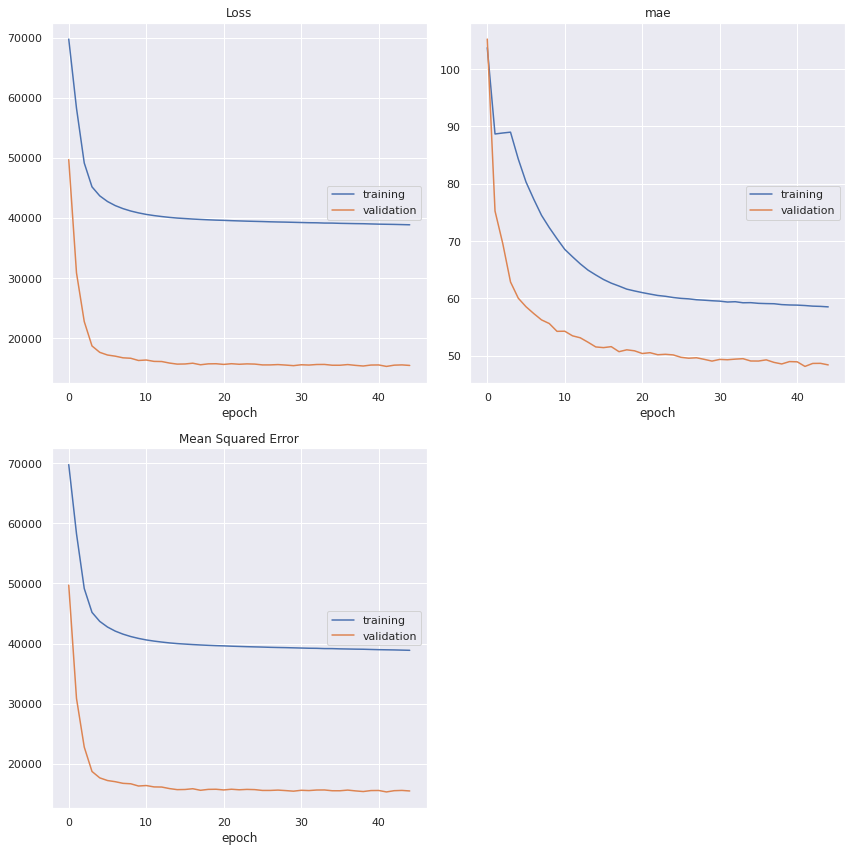